# Springboard Regression Case Study - The Red Wine Dataset - Tier 3

Welcome to the Springboard Regression case study! Please note: this is ***Tier 3*** of the case study.

This case study was designed for you to **use Python to apply the knowledge you've acquired in reading *The Art of Statistics* (hereinafter *AoS*) by Professor Spiegelhalter**. Specifically, the case study will get you doing regression analysis; a method discussed in Chapter 5 on p.121. It might be useful to have the book open at that page when doing the case study to remind you of what it is we're up to (but bear in mind that other statistical concepts, such as training and testing, will be applied, so you might have to glance at other chapters too).  

The aim is to ***use exploratory data analysis (EDA) and regression to predict alcohol levels in wine with a model that's as accurate as possible***. 

We'll try a *univariate* analysis (one involving a single explanatory variable) as well as a *multivariate* one (involving multiple explanatory variables), and we'll iterate together towards a decent model by the end of the notebook. The main thing is for you to see how regression analysis looks in Python and jupyter, and to get some practice implementing this analysis.

Throughout this case study, **questions** will be asked in the markdown cells. Try to **answer these yourself in a simple text file** when they come up. Most of the time, the answers will become clear as you progress through the notebook. Some of the answers may require a little research with Google and other basic resources available to every data scientist. 

For this notebook, we're going to use the red wine dataset, wineQualityReds.csv. Make sure it's downloaded and sitting in your working directory. This is a very common dataset for practicing regression analysis and is actually freely available on Kaggle, [here](https://www.kaggle.com/piyushgoyal443/red-wine-dataset).

You're pretty familiar with the data science pipeline at this point. This project will have the following structure: 
**1. Sourcing and loading** 
- Import relevant libraries
- Load the data 
- Exploring the data
- Choosing a dependent variable
 
**2. Cleaning, transforming, and visualizing**
- Visualizing correlations
  
  
**3. Modeling** 
- Train/Test split
- Making a Linear regression model: your first model
- Making a Linear regression model: your second model: Ordinary Least Squares (OLS) 
- Making a Linear regression model: your third model: multiple linear regression
- Making a Linear regression model: your fourth model: avoiding redundancy

**4. Evaluating and concluding** 
- Reflection 
- Which model was best?
- Other regression algorithms

### 1. Sourcing and loading

#### 1a. Import relevant libraries 

In [1]:
# Import relevant libraries and packages.
'''To improve legibility, my answers for this section are formatted as
multi-line strings.'''
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import statsmodels.api as sm # What does this do?
'''Cross-sectional methods & models'''
# from statsmodels.graphics.api import abline_plot # What does this do?
'''Plots a line given a slope and intercept. Not needed'''
from sklearn.metrics import mean_squared_error, r2_score # What does this do?
'''self-explanatory'''
from sklearn.model_selection import train_test_split #  What does this do?
'''self-explanatory'''
from sklearn import linear_model, preprocessing # What does this do?
'''self-explanatory'''
#import warnings # For handling error messages.
# Don't worry about the following two instructions: they just suppress warnings that could occur later. 

'''
Understanding how to suppress warnings is useful, but is it necessary here?

Future warnings exist for a reason. What syntax is used in this notebook 
that will soon be deprecated? Is it prohibitively difficult or expensive to
update these notebook exercises once every few years?

It took more time to write this comment than it typically takes to rewrite
syntax to comply with newly or soon-to-be implemented standards.
'''

#warnings.simplefilter(action="ignore", category=FutureWarning)
#warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")
;

''

In [2]:
sns.set_palette(sns.color_palette("rocket"))

In [3]:
def hr(letter: str='-') -> str:
    '''Horizontal rule. Return a string repeated 79 times. hr('_') emulates 
    html <hr>.
    '''
    return 79 * letter
def col_range(col: pd.Series) -> str:
    '''For a pandas Series containing numeric data, return the minimum and
    maximum values as a string formatted in this style: [min, max].
    '''
    if pd.api.types.is_numeric_dtype(col):
        return f'[{col.min():.1f}, {f"{col.max():.1f}".rjust(6)}]'
def df_check(
        data: pd.DataFrame, shape: bool=True, cols:bool=True,
        head: bool=True, ind: bool=True) -> None:
    '''Alternative to the pandas DataFrame.info() method. Print a summary
    of a dataframe object. Print shape and column information, including name,
    dtype, number of unique values, and percentage of values that is Null. If
    column has a numeric dtype, print min, max and mean.
    
    Arguments:
    data - dataframe object
    ind, shape, head, cols - if True, print data.index, data.shape, 
    data.head(3), and the column summary, respectively
    '''
    print(f'{type(data)}\n{hr()}')
    if ind:
        print(f'index: {data.index}\n{hr()}')
    if shape:
        print('shape:')
        if len(data.shape) <= 2:
            print(f'{len(data)} rows x {len(data.columns)} columns\n{hr()}')
        else:
            print(f'shape: {data.shape}\n{hr()}')
    if list(data.columns) and cols:
        numeric_cols = [
            col for col in list(data.columns) 
            if pd.api.types.is_numeric_dtype(data[col])\
        ]
        if numeric_cols: 
            num_summary = f'[x₀,{"xₙ".rjust(7)}]  {"x̄".rjust(7)}'
        else:
            num_summary = ''
        col_w = 3 + len(max(data.columns, key=len))
        print('column'.ljust(col_w) + 'dtype'.ljust(10)
              + 'value counts by type'.rjust(len(f'{len(data)}') + 17) 
              + f'   {num_summary}')
        print('------'.ljust(col_w) + '-----'.ljust(10)
              + (len(f'{len(data)}') + 17) * '-' + '   ' 
              + len(num_summary)*'-')
        for col in data.columns:
            uniq_vals = len(pd.unique(data[col]))
            col_summary = (
                f'{col}'.ljust(col_w) + f'{data[col].dtype}'[:8].ljust(10) 
                + f'{uniq_vals}'.rjust(len(f'{len(data)}')) + ' unique, '
                + f'{100* data[col].isna().sum()/len(data):.0f}'.rjust(2) 
                + '% null   '
            )
            if pd.api.types.is_numeric_dtype(data[col]):
                col_summary = col_summary + (
                    f'{col_range(data[col])}  '
                    + f'{np.mean(data[col]):.1f}'.rjust(6)
                )
            print(col_summary)
    print(hr() + '\n\n')
    if head:
        print('first 3 rows:\n')
        print(data.head(3))
        print(hr())
def col_label(col_name: str) -> str:
    '''Return a column label formatted as readable string.
    '''
    col_name = col_name.replace('.', ' ').replace('_', ' ').split()
    col_name = [col_name[0].title()] + [_.lower() for _ in col_name[1:]]
    return ' '.join(col_name).replace('ph', 'pH')
def plot_label(plot_title:str, x_col:str, y_col: str) -> None:
    '''Add axes labels and title to existing plot.
    '''
    plt.xlabel(col_label(x_col))
    plt.ylabel(col_label(y_col))
    plt.title(plot_title)
def scatter(
            plot_title: str, data: pd.DataFrame, x_col: str, y_col: str, 
            size: tuple[float]=(7, 7), show: bool = True, 
            add_corr: bool=False, **plot_options) -> None:
    '''Plot a scatter plot. Label axes based on column names.
    
    Arguments:
    plot_title -- title of plot
    data -- DataFrame object containing columns to plot
    x_col -- name of x column
    y_col -- name of y column
    size -- plot size set using plt.figure(figsize=size)
    show -- if true, call plt.show()
    add_corr -- if true - plot a "perfect correlation" line
    **plot_options -- keyword arguments to pass to sns.scatterplot
    
    '''
    fig = plt.figure(figsize=size)
    ax = sns.scatterplot(x=data[x_col], y=data[y_col], 
                         **plot_options)
    plot_label(plot_title, x_col, y_col)
    if add_corr:
        min_xy = min([min(data[x_col]), min(data[y_col])])
        max_xy = max([max(data[x_col]), max(data[y_col])])
        c = 0.05 * (max_xy - min_xy)
        min_xy -= c
        max_xy += c
        xy = [min_xy, max_xy]
        sns.lineplot(
            x=xy, y=xy, label = 'Correlation = 1', ls='--',
            color=sns.color_palette('rocket')[3]
        )
        plt.legend(loc='lower left', bbox_to_anchor=(0.6, 0.2))
    if show:
        plt.show();

#### 1b. Load the data

In [4]:
# Load the data. 
reds = pd.read_csv('data/raw/wineQualityReds.csv')

#### 1c. Exploring the data

In [5]:
# Check out its appearance. 
reds.head(3)

,Unnamed: 0,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
0,1,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,2,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,3,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5


In [6]:
# Another very useful method to call on a recently imported dataset is .info(). Call it here to get a good
# overview of the data
df_check(reds, head=0)

<class 'pandas.core.frame.DataFrame'>
-------------------------------------------------------------------------------
index: RangeIndex(start=0, stop=1599, step=1)
-------------------------------------------------------------------------------
shape:
1599 rows x 13 columns
-------------------------------------------------------------------------------
column                 dtype      value counts by type   [x₀,     xₙ]       x̄
------                 -----     ---------------------   ---------------------
Unnamed: 0             int64     1599 unique,  0% null   [1.0, 1599.0]   800.0
fixed.acidity          float64     96 unique,  0% null   [4.6,   15.9]     8.3
volatile.acidity       float64    143 unique,  0% null   [0.1,    1.6]     0.5
citric.acid            float64     80 unique,  0% null   [0.0,    1.0]     0.3
residual.sugar         float64     91 unique,  0% null   [0.9,   15.5]     2.5
chlorides              float64    153 unique,  0% null   [0.0,    0.6]     0.1
free.sulfur.di

What can you infer about the nature of these variables, as output by the info() method?

Which variables might be suitable for regression analysis, and why? For those variables that aren't suitable for regression analysis, is there another type of statistical modeling for which they are suitable?

In [7]:
# We should also look more closely at the dimensions of the dataset. 
reds.shape

(1599, 13)

#### 1d. Choosing a dependent variable

We now need to pick a dependent variable for our regression analysis: a variable whose values we will predict. 

'Quality' seems to be as good a candidate as any. Let's check it out. One of the quickest and most informative ways to understand a variable is to make a histogram of it. This gives us an idea of both the center and spread of its values. 

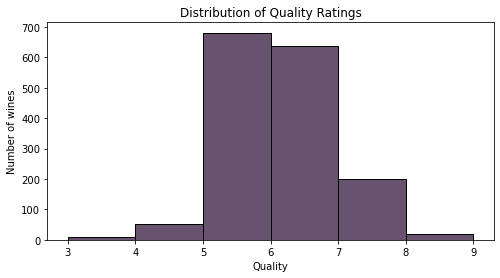

In [8]:
# Making a histogram of the quality variable.
fig, ax = plt.subplots(figsize=(8,4))
_ = sns.histplot(
    reds.quality, 
    bins=sorted(pd.unique(reds.quality)) + [1 + reds.quality.max()]
)
plot_label('Distribution of Quality Ratings', 'Quality', 'Number of wines')
plt.show();

We can see so much about the quality variable just from this simple visualization. Answer yourself: what value do most wines have for quality? What is the minimum quality value below, and the maximum quality value? What is the range? Remind yourself of these summary statistical concepts by looking at p.49 of the *AoS*.

But can you think of a problem with making this variable the dependent variable of regression analysis? Remember the example in *AoS* on p.122 of predicting the heights of children from the heights of parents? Take a moment here to think about potential problems before reading on. 

The issue is this: quality is a *discrete* variable, in that its values are integers (whole numbers) rather than floating point numbers. Thus, quality is not a *continuous* variable. But this means that it's actually not the best target for regression analysis. 

Before we dismiss the quality variable, however, let's verify that it is indeed a discrete variable with some further exploration. 

In [9]:
# Get a basic statistical summary of the variable 
reds.quality.describe()

count    1599.000000
mean        5.636023
std         0.807569
min         3.000000
25%         5.000000
50%         6.000000
75%         6.000000
max         8.000000
Name: quality, dtype: float64

All quantiles are quantized to integers, and there are only 6 unique values for this column. This is categorical data.

In [10]:
# Get a list of the values of the quality variable, and the number of occurrences of each. 
reds.quality.value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

The outputs of the describe() and value_counts() methods are consistent with our histogram, and since there are just as many values as there are rows in the dataset, we can infer that there are no NAs for the quality variable. 

But scroll up again to when we called info() on our wine dataset. We could have seen there, already, that the quality variable had int64 as its type. As a result, we had sufficient information, already, to know that the quality variable was not appropriate for regression analysis. Did you figure this out yourself? If so, kudos to you!

The quality variable would, however, conduce to proper classification analysis. This is because, while the values for the quality variable are numeric, those numeric discrete values represent *categories*; and the prediction of category-placement is most often best done by classification algorithms. You saw the decision tree output by running a classification algorithm on the Titanic dataset on p.168 of Chapter 6 of *AoS*. For now, we'll continue with our regression analysis, and continue our search for a suitable dependent variable. 

Now, since the rest of the variables of our wine dataset are continuous, we could — in theory — pick any of them. But that does not mean that are all equally sutiable choices. What counts as a suitable dependent variable for regression analysis is determined not just by *intrinsic* features of the dataset (such as data types, number of NAs etc) but by *extrinsic* features, such as, simply, which variables are the most interesting or useful to predict, given our aims and values in the context we're in. Almost always, we can only determine which variables are sensible choices for dependent variables with some **domain knowledge**. 

Not all of you might be wine buffs, but one very important and interesting quality in wine is [acidity](https://waterhouse.ucdavis.edu/whats-in-wine/fixed-acidity). As the Waterhouse Lab at the University of California explains, 'acids impart the sourness or tartness that is a fundamental feature in wine taste.  Wines lacking in acid are "flat." Chemically the acids influence titrable acidity which affects taste and pH which affects  color, stability to oxidation, and consequantly the overall lifespan of a wine.'

If we cannot predict quality, then it seems like **fixed acidity** might be a great option for a dependent variable. Let's go for that.

So if we're going for fixed acidity as our dependent variable, what we now want to get is an idea of *which variables are related interestingly to that dependent variable*. 

We can call the .corr() method on our wine data to look at all the correlations between our variables. As the [documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html) shows, the default correlation coefficient is the Pearson correlation coefficient (p.58 and p.396 of the *AoS*); but other coefficients can be plugged in as parameters. Remember, the Pearson correlation coefficient shows us how close to a straight line the data-points fall, and is a number between -1 and 1. 

In [11]:
reds.drop(columns='Unnamed: 0', inplace=True)

In [12]:
# Call the .corr() method on the wine dataset 
print(f'fixed acidity columns: \nPearson correlation coefficients by '
      + f'column\n{hr()}')
print(reds.corr()['fixed.acidity'][1:])
print(hr())
reds.corr()

fixed acidity columns: 
Pearson correlation coefficients by column
-------------------------------------------------------------------------------
volatile.acidity       -0.256131
citric.acid             0.671703
residual.sugar          0.114777
chlorides               0.093705
free.sulfur.dioxide    -0.153794
total.sulfur.dioxide   -0.113181
density                 0.668047
pH                     -0.682978
sulphates               0.183006
alcohol                -0.061668
quality                 0.124052
Name: fixed.acidity, dtype: float64
-------------------------------------------------------------------------------


,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
fixed.acidity,1.000000,-0.256131,0.671703,0.114777,0.093705,-0.153794,-0.113181,0.668047,-0.682978,0.183006,-0.061668,0.124052
volatile.acidity,-0.256131,1.000000,-0.552496,0.001918,0.061298,-0.010504,0.076470,0.022026,0.234937,-0.260987,-0.202288,-0.390558
citric.acid,0.671703,-0.552496,1.000000,0.143577,0.203823,-0.060978,0.035533,0.364947,-0.541904,0.312770,0.109903,0.226373
residual.sugar,0.114777,0.001918,0.143577,1.000000,0.055610,0.187049,0.203028,0.355283,-0.085652,0.005527,0.042075,0.013732
chlorides,0.093705,0.061298,0.203823,0.055610,1.000000,0.005562,0.047400,0.200632,-0.265026,0.371260,-0.221141,-0.128907
free.sulfur.dioxide,-0.153794,-0.010504,-0.060978,0.187049,0.005562,1.000000,0.667666,-0.021946,0.070377,0.051658,-0.069408,-0.050656
total.sulfur.dioxide,-0.113181,0.076470,0.035533,0.203028,0.047400,0.667666,1.000000,0.071269,-0.066495,0.042947,-0.205654,-0.185100
density,0.668047,0.022026,0.364947,0.355283,0.200632,-0.021946,0.071269,1.000000,-0.341699,0.148506,-0.496180,-0.174919
pH,-0.682978,0.234937,-0.541904,-0.085652,-0.265026,0.070377,-0.066495,-0.341699,1.000000,-0.196648,0.205633,-0.057731
sulphates,0.183006,-0.260987,0.312770,0.005527,0.371260,0.051658,0.042947,0.148506,-0.196648,1.000000,0.093595,0.251397


Ok - you might be thinking, but wouldn't it be nice if we visualized these relationships? It's hard to get a picture of the correlations between the variables without anything visual. 

Very true, and this brings us to the next section.

### 2. Cleaning, Transforming, and Visualizing 

#### 2a. Visualizing correlations 
The heading of this stage of the data science pipeline ('Cleaning, Transforming, and Visualizing') doesn't imply that we have to do all of those operations in *that order*. Sometimes (and this is a case in point) our data is already relatively clean, and the priority is to do some visualization. Normally, however, our data is less sterile, and we have to do some cleaning and transforming first prior to visualizing. 

Now that we've chosen **fixed acidity** as our dependent variable for regression analysis, we can begin by plotting the pairwise relationships in the dataset, to check out how our variables relate to one another.

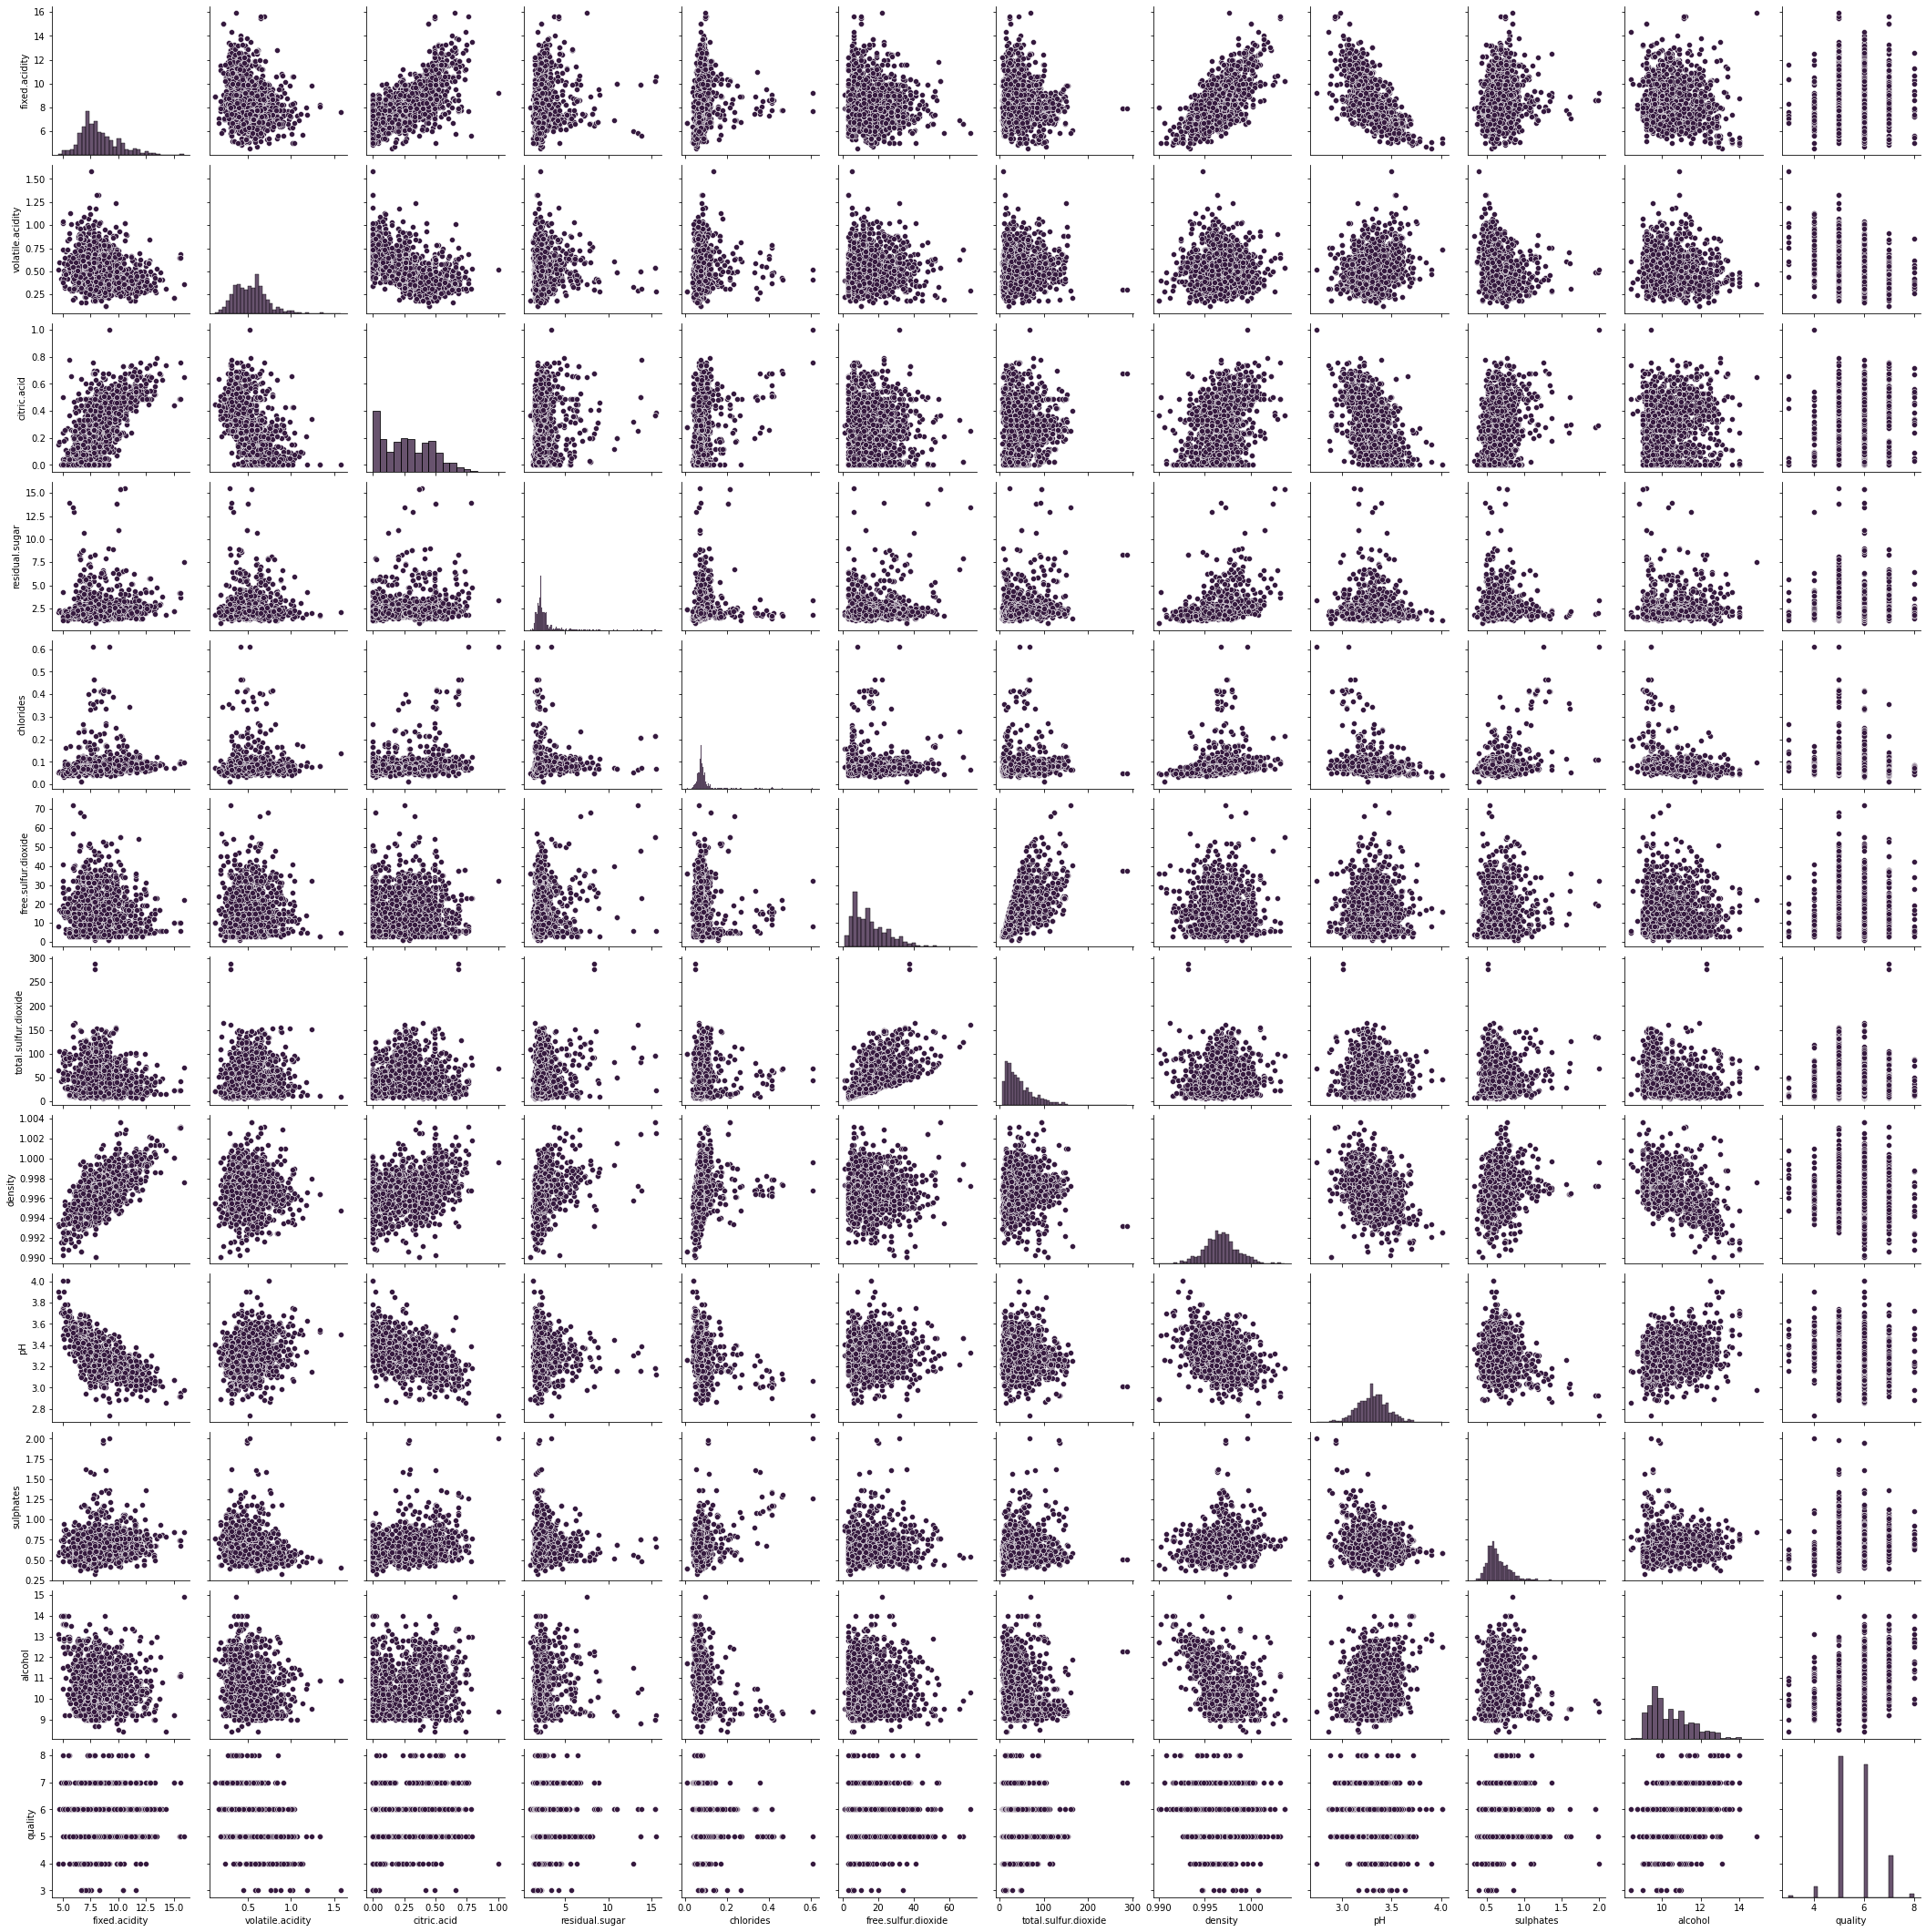

In [13]:
# Make a pairplot of the wine data
_ = sns.pairplot(reds)
plt.show();

If you've never executed your own Seaborn pairplot before, just take a moment to look at the output. They certainly output a lot of information at once. What can you infer from it? What can you *not* justifiably infer from it?

... All done? 

Here's a couple things you might have noticed: 
- a given cell value represents the correlation that exists between two variables 
- on the diagonal, you can see a bunch of histograms. This is because pairplotting the variables with themselves would be pointless, so the pairplot() method instead makes histograms to show the distributions of those variables' values. This allows us to quickly see the shape of each variable's values.  
- the plots for the quality variable form horizontal bands, due to the fact that it's a discrete variable. We were certainly right in not pursuing a regression analysis of this variable.
- Notice that some of the nice plots invite a line of best fit, such as alcohol vs density. Others, such as citric acid vs alcohol, are more inscrutable.

So we now have called the .corr() method, and the .pairplot() Seaborn method, on our wine data. Both have flaws. Happily, we can get the best of both worlds with a heatmap. 

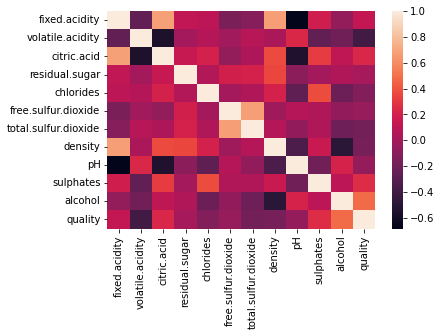

In [14]:
# Make a heatmap of the data 
sns.heatmap(reds.corr())
plt.show();

Take a moment to think about the following questions:
- How does color relate to extent of correlation?
- How might we use the plot to show us interesting relationships worth investigating? 
- More precisely, what does the heatmap show us about the fixed acidity variable's relationship to the density variable? 

There is a relatively strong correlation between the density and fixed acidity variables respectively. In the next code block, call the scatterplot() method on our sns object. Make the x-axis parameter 'density', the y-axis parameter 'fixed.acidity', and the third parameter specify our wine dataset.  

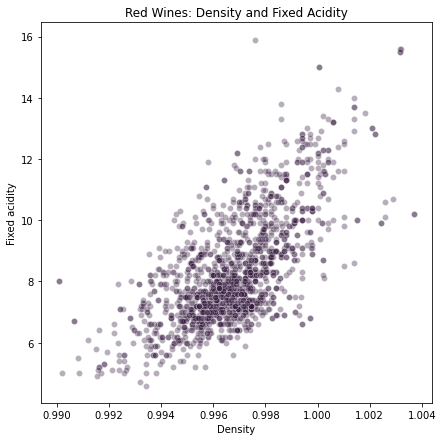

In [15]:
# Plot density against fixed.acidity
scatter(
    'Red Wines: Density and Fixed Acidity', reds, 
    'density', 'fixed.acidity', alpha=0.35
)


We can see a positive correlation, and quite a steep one. There are some outliers, but as a whole, there is a steep looking line that looks like it ought to be drawn. 

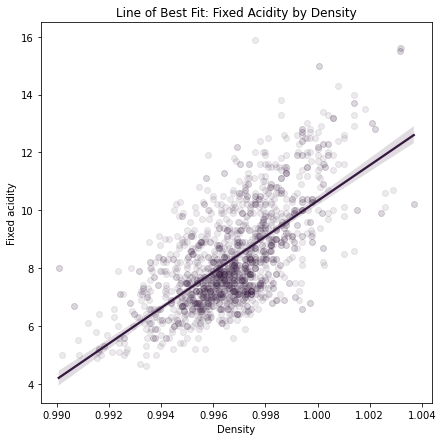

In [16]:
# Call the regplot method on your sns object, with parameters: x = 'density', y = 'fixed.acidity'
fig = plt.figure(figsize=(7, 7))
ax = sns.regplot(
    x=reds['density'], y=reds['fixed.acidity'], 
    scatter_kws={'alpha':0.09}
)
plot_label(
    'Line of Best Fit: Fixed Acidity by Density',
    'density', 'fixed.acidity'
)
plt.show()

The line of best fit matches the overall shape of the data, but it's clear that there are some points that deviate from the line, rather than all clustering close. 

Let's see if we can predict fixed acidity based on density using linear regression. 

### 3. Modeling 

#### 3a. Train/Test Split
While this dataset is super clean, and hence doesn't require much for analysis, we still need to split our dataset into a test set and a training set.

You'll recall from p.158 of *AoS* that such a split is important good practice when evaluating statistical models. On p.158, Professor Spiegelhalter was evaluating a classification tree, but the same applies when we're doing regression. Normally, we train with 75% of the data and test on the remaining 25%. 

To be sure, for our first model, we're only going to focus on two variables: fixed acidity as our dependent variable, and density as our sole independent predictor variable. 

We'll be using [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) here. Don't worry if not all of the syntax makes sense; just follow the rationale for what we're doing. 

In [17]:
# Subsetting our data into our dependent and independent variables.
lr_x, lr_y = reds.loc[:, 'density'].copy(), reds.loc[:, 'fixed.acidity'].copy()

# Split the data. This line uses the sklearn function train_test_split().
# The test_size parameter means we can train with 75% of the data, and test on 25%. 
lr_x_train, lr_x_test, lr_y_train, lr_y_test = train_test_split(lr_x, lr_y, test_size=0.25)
lr_x_train, lr_x_test, lr_y_train, lr_y_test = map(
    lambda pd_Series: pd_Series.to_numpy().reshape(-1, 1),
    (lr_x_train, lr_x_test, lr_y_train, lr_y_test)
)

In [18]:
# We now want to check the shape of the X train, y_train, X_test and y_test to make sure the proportions are right. 
assert round(len(lr_x_test)/len(reds), 2) == 0.25
for name, data in ('train', lr_x_train), ('test', lr_x_test):
    print(f'x_{name} shape: {data.shape}')

x_train shape: (1199, 1)
x_test shape: (400, 1)


#### 3b. Making a Linear Regression model: our first model
Sklearn has a [LinearRegression()](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) function built into the linear_model module. We'll be using that to make our regression model. 

In [19]:
# Create the model: make a variable called rModel, and use it linear_model.LinearRegression appropriately
lr_model = linear_model.LinearRegression()

In [20]:
# We now want to train the model on our test data.
lr_model.fit(lr_x_train, lr_y_train);

In [21]:
# Evaluate the model  
lr_model.score(lr_x_test, lr_y_test)

0.48514990324981166

The above score is called R-Squared coefficient, or the "coefficient of determination". It's basically a measure of how successfully our model predicts the variations in the data away from the mean: 1 would mean a perfect model that explains 100% of the variation. At the moment, our model explains only about 45% of the variation from the mean. There's more work to do!

In [22]:
# Use the model to make predictions about our test data
lr_y_predicted = lr_model.predict(lr_x_test)
reds_lr_model = pd.DataFrame(
    {
        'density': lr_x_test.flat, 
        'predicted_fixed_acidity': lr_y_predicted.flat,
        'observed_fixed_acidity': lr_y_test.flat
    }
)

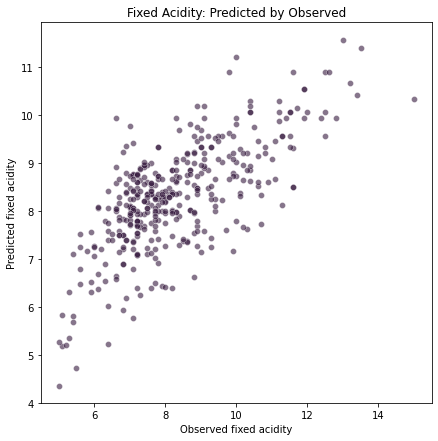

In [23]:
# Let's plot the predictions against the actual result. Use scatter()
scatter(
    'Fixed Acidity: Predicted by Observed', reds_lr_model,
    'observed_fixed_acidity', 'predicted_fixed_acidity', size=(7, 7),
    alpha=0.6
    
)

The above scatterplot represents how well the predictions match the actual results. 

Along the x-axis, we have the actual fixed acidity, and along the y-axis we have the predicted value for the fixed acidity.

There is a visible positive correlation, as the model has not been totally unsuccesful, but it's clear that it is not maximally accurate: wines with an actual fixed acidity of just over 10 have been predicted as having acidity levels from about 6.3 to 13.

Let's build a similar model using a different package, to see if we get a better result that way.

#### 3c. Making a Linear Regression model: our second model: Ordinary Least Squares (OLS)

In [24]:
# Create the test and train sets. Here, we do things slightly differently.  
# We make the explanatory variable X as before.
ols_x, ols_y = map(
    lambda col: reds.loc[:, col].copy().to_numpy().reshape(-1, 1), 
    ['density', 'fixed.acidity']
)

# But here, reassign X the value of adding a constant to it. This is required for Ordinary Least Squares Regression.
# Further explanation of this can be found here: 
# https://www.statsmodels.org/devel/generated/statsmodels.regression.linear_model.OLS.html
ols_x = sm.tools.add_constant(ols_x)

In [25]:
# Split the data using train_test_split()
ols_x_train, ols_x_test, ols_y_train, ols_y_test = (
    train_test_split(ols_x, ols_y))

In [26]:
# Create the model
ols_model = sm.OLS(ols_y_train, ols_x_train)

# Fit the model with fit() 
ols_results = ols_model.fit()

In [27]:
# Evaluate the model with .summary()
ols_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.431
Model:                            OLS   Adj. R-squared:                  0.431
Method:                 Least Squares   F-statistic:                     907.5
Date:                Sat, 09 Jul 2022   Prob (F-statistic):          7.58e-149
Time:                        16:36:15   Log-Likelihood:                -2029.6
No. Observations:                1199   AIC:                             4063.
Df Residuals:                    1197   BIC:                             4073.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -601.5830     20.246    -29.714      0.000    -641.305    -561.861
x1           611.9214     20.313     30.125      0.000     572.068     651.774
==============================================================================
Omnibus:                       91.586   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              114.663
Skew:                           0.679   Prob(JB):                     1.26e-25
Kurtosis:                       3.671   Cond. No.                     1.07e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.07e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

One of the great things about Statsmodels (sm) is that you get so much information from the summary() method. 

There are lots of values here, whose meanings you can explore at your leisure, but here's one of the most important: the R-squared score is 0.455, the same as what it was with the previous model. This makes perfect sense, right? It's the same value as the score from sklearn, because they've both used the same algorithm on the same data.

Here's a useful link you can check out if you have the time: https://www.theanalysisfactor.com/assessing-the-fit-of-regression-models/

In [28]:
# Let's use our new model to make predictions of the dependent variable y. Use predict(), and plug in X_test as the parameter
ols_y_predicted = ols_results.predict(ols_x_test)
reds_model_ols = pd.DataFrame({
    'density': ols_x_test[:, -1],
    'observed fixed acidity': ols_y_test.flat, 
    'predicted fixed acidity': ols_y_predicted.flat,
})

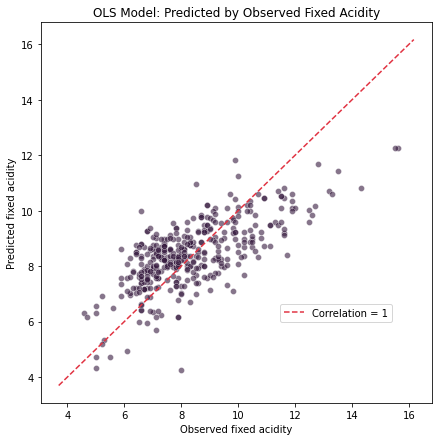

In [29]:
# Plot the predictions
# Build a scatterplot
# Add a line for perfect correlation. Can you see what this line is doing? Use plot()
# Label it nicely
scatter(
    'OLS Model: Predicted by Observed Fixed Acidity', reds_model_ols,
    'observed fixed acidity', 'predicted fixed acidity', 
    add_corr=True, alpha=0.6
)
plt.show();

The red line shows a theoretically perfect correlation between our actual and predicted values - the line that would exist if every prediction was completely correct. It's clear that while our points have a generally similar direction, they don't match the red line at all; we still have more work to do. 

To get a better predictive model, we should use more than one variable.

#### 3d. Making a Linear Regression model: our third model: multiple linear regression
Remember, as Professor Spiegelhalter explains on p.132 of *AoS*, including more than one explanatory variable into a linear regression analysis is known as ***multiple linear regression***. 

In [30]:
# Create test and train datasets
# This is again very similar, but now we include more columns in the predictors
# Include all columns from data in the explanatory variables X except fixed.acidity and quality (which was an integer)
mlr_x = reds.copy().drop(['fixed.acidity', 'quality'], axis='columns')
mlr_x = sm.tools.add_constant(mlr_x)
# Create constants for X, so the model knows its bounds
mlr_y = reds.loc[:, 'fixed.acidity'].copy()


# Split the data
mlr_x_train, mlr_x_test, mlr_y_train, mlr_y_test = train_test_split(mlr_x, mlr_y)


In [31]:
# We can use almost identical code to create the third model, because it is the same algorithm, just different inputs
# Create the model
mlr_model = sm.OLS(mlr_y_train, mlr_x_train)

# Fit the model
mlr_results = mlr_model.fit()

In [32]:
# Evaluate the model
mlr_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          fixed.acidity   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     807.2
Date:                Sat, 09 Jul 2022   Prob (F-statistic):               0.00
Time:                        16:36:15   Log-Likelihood:                -1149.8
No. Observations:                1199   AIC:                             2322.
Df Residuals:                    1188   BIC:                             2378.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 -653.4552     15.344    -42.586      0.000    -683.560    -623.350
volatile.acidity         0.2670      0.136      1.963      0.050       0.000       0.534
citric.acid              1.8908      0.159     11.866      0.000       1.578       2.203
residual.sugar          -0.2735      0.016    -16.900      0.000      -0.305      -0.242
chlorides               -3.6214      0.457     -7.921      0.000      -4.518      -2.724
free.sulfur.dioxide      0.0117      0.002      4.769      0.000       0.007       0.017
total.sulfur.dioxide    -0.0071      0.001     -8.631      0.000      -0.009      -0.005
density                676.4728     15.297     44.222      0.000     646.461     706.485
pH                      -5.3554      0.151    -35.509      0.000      -5.651      -5.059
sulphates               -0.6884      0.133     -5.173      0.000      -0.950      -0.427
alcohol                  0.5942      0.025     23.498      0.000       0.545       0.644
==============================================================================
Omnibus:                      142.710   Durbin-Watson:                   2.065
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              483.855
Skew:                           0.562   Prob(JB):                    8.55e-106
Kurtosis:                       5.902   Cond. No.                     6.97e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.97e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The R-Squared score shows a big improvement - our first model predicted only around 45% of the variation, but now we are predicting 87%!

In [33]:
# Use our new model to make predictions
'''The next 2 comments are instructions that have been moved here
from a code cell at the end of 3d.
'''
# (moved) Get predictions from rModel3
# (moved) Put the predictions & actual values into a dataframe
mlr_y_predicted = mlr_results.predict(mlr_x_test)
reds_model_mlr = pd.DataFrame({
        'predicted_fixed_acidity': mlr_y_predicted,
        'observed_fixed_acidity': mlr_y_test
})

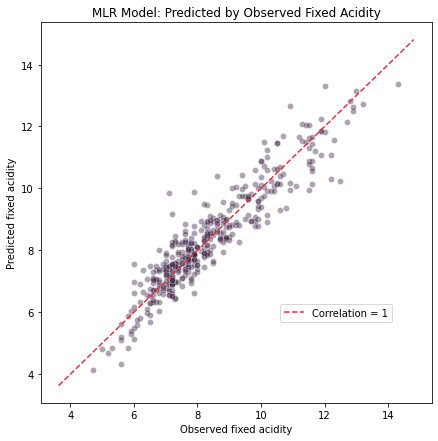

In [34]:
# Plot the predictions
# Build a scatterplot
# Add a line for perfect correlation
# Label it nicely
scatter(
    'MLR Model: Predicted by Observed Fixed Acidity',
    reds_model_mlr, 'observed_fixed_acidity', 'predicted_fixed_acidity',
    add_corr=True, alpha=0.4
)

We've now got a much closer match between our data and our predictions, and we can see that the shape of the data points is much more similar to the red line. 

We can check another metric as well - the RMSE (Root Mean Squared Error). The MSE is defined by Professor Spiegelhalter on p.393 of *AoS*, and the RMSE is just the square root of that value. This is a measure of the accuracy of a regression model. Very simply put, it's formed by finding the average difference between predictions and actual values. Check out p. 163 of *AoS* for a reminder of how this works. 

In [35]:
# Define a function to check the RMSE. Remember the def keyword needed to make functions? 
def rmse(predicted_y: np.ndarray, observed_y: np.ndarray) -> float:
    '''Return the root mean squared error for given predicted_y and
    observed_y.
    '''
    return np.sqrt(np.mean((predicted_y - observed_y)**2))

In [36]:
print(f'root mean squared error of tested models:\n{hr()}')
for model, predicted, observed in [
        ('simple linear', lr_y_predicted, lr_y_test), 
        ('ordinary least square', ols_y_predicted, ols_y_test),
        ('multiple linear OLS', mlr_y_predicted, mlr_y_test)
    ]:
    print(f'{model} regression'.ljust(39) 
          + f'RMSE ≈ {(rmse(predicted, observed)):.5f}'.rjust(15))

root mean squared error of tested models:
-------------------------------------------------------------------------------
simple linear regression                RMSE ≈ 1.21000
ordinary least square regression        RMSE ≈ 2.09818
multiple linear OLS regression          RMSE ≈ 0.61055


In [37]:
# Get predictions from rModel3
# Put the predictions & actual values into a dataframe
'''The instructions here are redundant. These prompts were addressed in a
previous cell.
''';

The RMSE tells us how far, on average, our predictions were mistaken. An RMSE of 0 would mean we were making perfect predictions. 0.6 signifies that we are, on average, about 0.6 of a unit of fixed acidity away from the correct answer. That's not bad at all.

#### 3e. Making a Linear Regression model: our fourth model: avoiding redundancy 

We can also see from our early heat map that volatile.acidity and citric.acid are both correlated with pH. We can make a model that ignores those two variables and just uses pH, in an attempt to remove redundancy from our model.

In [38]:
# Create test and train datasets
# Include the remaining six columns as predictors
mlr_r1_x = reds.copy().drop(
    ['fixed.acidity', 'quality', 'volatile.acidity', 'citric.acid'],
    axis='columns'
)

# Create constants for X, so the model knows its bounds
mlr_r1_x = sm.tools.add_constant(mlr_x)
mlr_r1_y = reds.loc[:, 'fixed.acidity'].copy()

# Split the data
mlr_r1_x_train, mlr_r1_x_test, mlr_r1_y_train, mlr_r1_y_test = (
    train_test_split(mlr_r1_x, mlr_r1_y)
)

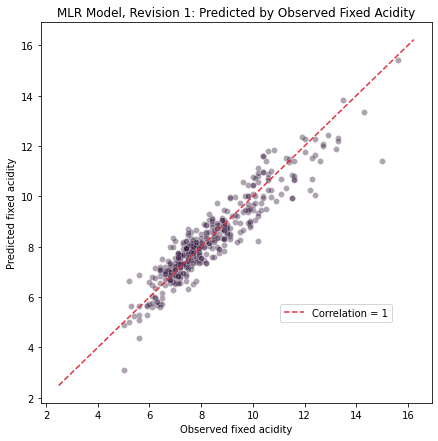

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          fixed.acidity   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     805.0
Date:                Sat, 09 Jul 2022   Prob (F-statistic):               0.00
Time:                        16:36:15   Log-Likelihood:                -1135.5
No. Observations:                1199   AIC:                             2293.
Df Residuals:                    1188   BIC:                             2349.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 -627.0340     14.925    -42.012      0.000    -656.317    -597.751
volatile.acidity         0.2571      0.137      1.884      0.060      -0.011       0.525
citric.acid              1.9131      0.152     12.566      0.000       1.614       2.212
residual.sugar          -0.2447      0.015    -16.582      0.000      -0.274      -0.216
chlorides               -3.8423      0.453     -8.485      0.000      -4.731      -2.954
free.sulfur.dioxide      0.0078      0.002      3.298      0.001       0.003       0.012
total.sulfur.dioxide    -0.0063      0.001     -7.901      0.000      -0.008      -0.005
density                650.3328     14.865     43.749      0.000     621.168     679.498
pH                      -5.3323      0.151    -35.251      0.000      -5.629      -5.036
sulphates               -0.7334      0.129     -5.694      0.000      -0.986      -0.481
alcohol                  0.5504      0.025     22.239      0.000       0.502       0.599
==============================================================================
Omnibus:                      103.015   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              395.468
Skew:                           0.332   Prob(JB):                     1.33e-86
Kurtosis:                       5.734   Cond. No.                     6.94e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.94e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [39]:
# Create the fifth model
mlr_r1_model = sm.OLS(mlr_r1_y_train, mlr_r1_x_train)

# Fit the model
mlr_r1_results = mlr_r1_model.fit()

# Evaluate the model

mlr_r1_y_predicted = mlr_r1_results.predict(mlr_r1_x_test)
reds_model_mlr_r1 = pd.DataFrame({
        'predicted_fixed_acidity': mlr_r1_y_predicted,
        'observed_fixed_acidity': mlr_r1_y_test
})
scatter(
    'MLR Model, Revision 1: Predicted by Observed Fixed Acidity',
    reds_model_mlr_r1, 'observed_fixed_acidity', 'predicted_fixed_acidity',
    add_corr=True, alpha=0.4
)
mlr_r1_results.summary()



The R-squared score has reduced, showing us that actually, the removed columns were important.

### Conclusions & next steps

Congratulations on getting through this implementation of regression and good data science practice in Python! 

Take a moment to reflect on which model was the best, before reading on.

.
.
.

Here's one conclusion that seems right. While our most predictively powerful model was rModel3, this model had explanatory variables that were correlated with one another, which made some redundancy. Our most elegant and economical model was rModel4 - it used just a few predictors to get a good result. 

All of our models in this notebook have used the OLS algorithm - Ordinary Least Squares. There are many other regression algorithms, and if you have time, it would be good to investigate them. You can find some examples [here](https://www.statsmodels.org/dev/examples/index.html#regression). Be sure to make a note of what you find, and chat through it with your mentor at your next call.
